<a href="https://colab.research.google.com/github/bilal99u/Stroke_prediction/blob/main/Copy_of_Kaggle_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================================================
# ECE 657: Assignment 4 - Stroke Prediction
# STUDENT STARTER CODE
# ==============================================================================

# --- Import Essential Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preprocessing & Pipeline ---
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Machine Learning Models ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from google.colab import drive
drive.mount('/content/drive')

# --- Set up global parameters ---
# Set a random seed for reproducibility
RANDOM_STATE = 42
# Define the cross-validation strategy
# Using StratifiedKFold is good practice for imbalanced datasets
CV_SPLITS = 5
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
# --- Set Plot Style ---
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams['figure.figsize'] = [10, 6]

print("✅ Libraries imported and initial setup complete.")
print(f"Random State: {RANDOM_STATE}")
print(f"CV Folds: {CV_SPLITS}")

# ==============================================================================
# Part 0: Load Data
# ==============================================================================

# TODO: Load train.csv, test.csv, and sample_submission.csv here
# HINT: Use a try-except block to catch FileNotFoundError
try:
    train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
    sample_submission_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')
    print("\nData loaded successfully!")
    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"\n❌ ERROR: {e}. Please ensure all CSV files are in the correct directory.")
    # Create empty dataframes to avoid further errors in the notebook
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

# Now you can begin with Part A...

Mounted at /content/drive
✅ Libraries imported and initial setup complete.
Random State: 42
CV Folds: 5

Data loaded successfully!
Training data shape: (3576, 12)
Test data shape: (1533, 11)


In [2]:
train_df.head()
count = 0
strocked = []
for i in range(len(train_df)):
    if train_df.iloc[i]['stroke'] == 1:
        #print(train_df.iloc[i])
        strocked.append(train_df.iloc[i])
        count +=1
        if count == 10000:
          break
print(len(strocked), np.shape(strocked))
strocked = pd.DataFrame(strocked)
strocked.head()

print(train_df.head())
print("\nShape:", train_df.shape)
print("\nColumns:", train_df.columns.tolist())
print("\nData Types:")
print(train_df.info())
print("\nMissing Values:")
print(train_df.isnull().sum())

174 (174, 12)
      id  gender   age  hypertension  heart_disease ever_married  \
0  45163  Female  47.0             0              0          Yes   
1  22330  Female  45.0             0              0          Yes   
2  43016    Male  10.0             0              0           No   
3  40980    Male  79.0             1              0          Yes   
4   1183    Male  39.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban              99.36  23.8           smokes   
1  Self-employed          Urban              82.94  29.3          Unknown   
2       children          Urban              70.70  25.4          Unknown   
3  Self-employed          Urban              72.04  23.6  formerly smoked   
4        Private          Rural              84.18   NaN           smokes   

   stroke  
0       0  
1       0  
2       0  
3       0  
4       0  

Shape: (3576, 12)

Columns: ['id', 'gende

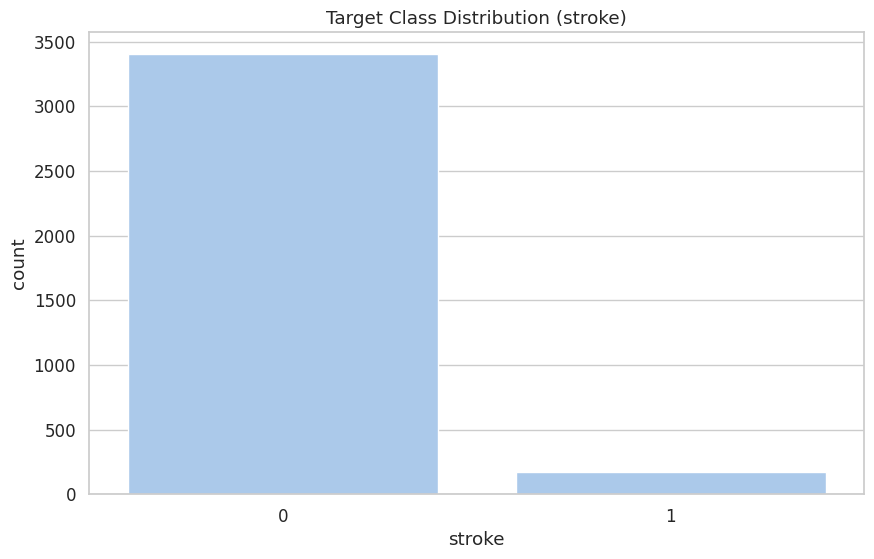

stroke
0    0.951342
1    0.048658
Name: proportion, dtype: float64


In [3]:

sns.countplot(x='stroke', data=train_df)
plt.title("Target Class Distribution (stroke)")
plt.show()

# Value counts
print(train_df['stroke'].value_counts(normalize=True))

/tmp/ipython-input-4-4264801882.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Stroke')


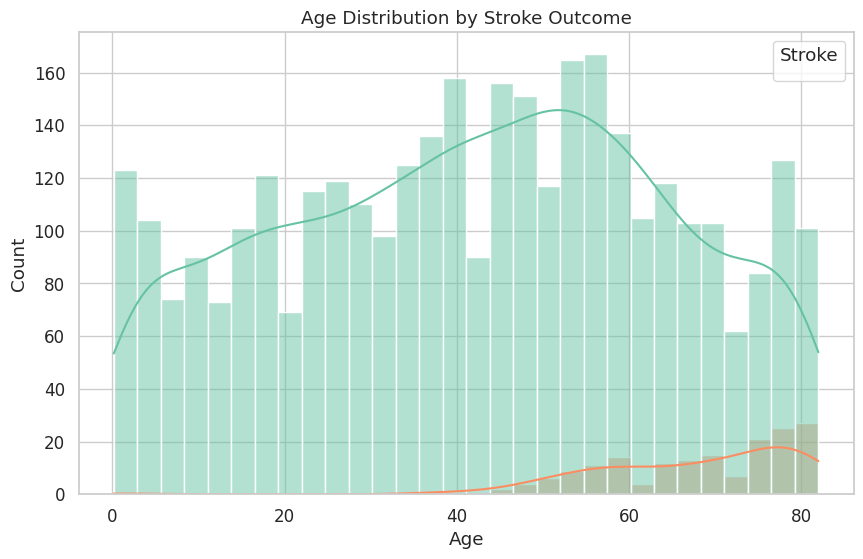

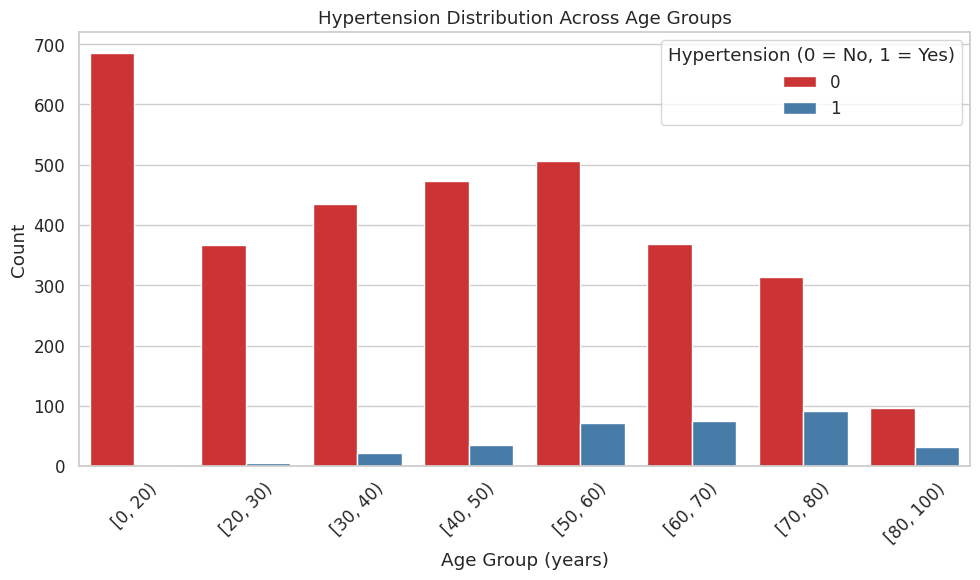

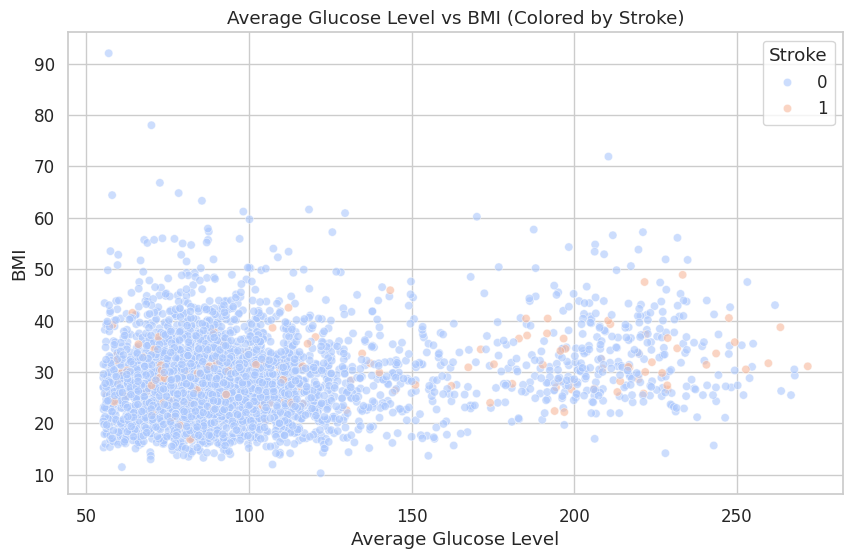

In [4]:
sns.histplot(data=train_df, x='age', hue='stroke', kde=True, bins=30, palette='Set2')
plt.title('Age Distribution by Stroke Outcome')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Stroke')
plt.show()

# Create age bins
train_df_for_plot = train_df.copy()
train_df_for_plot['age_bin'] = pd.cut(train_df['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 100], right=False)

# Plot count of hypertension in each age group
sns.countplot(data=train_df_for_plot, x='age_bin', hue='hypertension', palette='Set1')
plt.title('Hypertension Distribution Across Age Groups')
plt.xlabel('Age Group (years)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Hypertension (0 = No, 1 = Yes)')
plt.tight_layout()
plt.show()

sns.scatterplot(data=train_df, x='avg_glucose_level', y='bmi', hue='stroke', alpha=0.6, palette='coolwarm')
plt.title('Average Glucose Level vs BMI (Colored by Stroke)')
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.legend(title='Stroke')
plt.show()


In [5]:

baseline_tree_df = train_df.copy()
baseline_tree_df = baseline_tree_df.drop(columns='id', errors='ignore')
baseline_tree_df['bmi'] = baseline_tree_df['bmi'].fillna(baseline_tree_df['bmi'].mean())

X = baseline_tree_df.drop(columns = 'stroke')
Y = baseline_tree_df['stroke']
X_encoded = pd.get_dummies(X)
dec_tree_obj = DecisionTreeClassifier(random_state = RANDOM_STATE)
dt_results = cross_validate(dec_tree_obj, X_encoded, Y, cv = cv, scoring = 'roc_auc')
dt_results_test = dt_results['test_score']

print("Decision Tree mean: ", dt_results_test.mean(), "          STD:", dt_results_test.std()  )
#

Decision Tree mean:  0.550752569750367           STD: 0.014184580147390128


In [6]:

from sklearn.model_selection import GridSearchCV
# This section is for the DT with full preprocessing pipeline

# Identify types of features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Transfomers

num_trans = Pipeline(steps = [('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())] )
cat_trans = Pipeline(steps = [('imputer',SimpleImputer(strategy='constant', fill_value='missing')),('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers = [('num', num_trans, numeric_features),('cat', cat_trans, categorical_features)])

model_knn = Pipeline(steps = [('preprocessor', preprocessor),('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance'))])
model_logreg = Pipeline(steps = [('preprocessor', preprocessor),('classifier', LogisticRegression(max_iter=1000, class_weight='balanced' , random_state=RANDOM_STATE))])


results_knn = cross_validate(model_knn, X, Y, cv = cv, scoring = scoring)
results_logreg = cross_validate(model_logreg, X, Y, cv = cv, scoring = scoring)

# XGB

neg, pos = np.bincount(Y)
scale_weight = neg / pos
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100],
    'classifier__scale_pos_weight': [scale_weight]  # from earlier
}


model_xgb = Pipeline(steps = [('preprocessor', preprocessor),('classifier', xgb.XGBClassifier(eval_metric='logloss' ,random_state=RANDOM_STATE))])

results_xgb = cross_validate(model_xgb, X, Y, cv = cv, scoring = scoring)

def print_cv_results(name, scores):
    for metric in scores:
        if "test_" in metric:
            m = metric.replace("test_", "")
            values = scores[metric]


summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Logistic Regression': [
        results_logreg['test_accuracy'].mean(),
        results_logreg['test_precision'].mean(),
        results_logreg['test_recall'].mean(),
        results_logreg['test_f1'].mean(),
        results_logreg['test_roc_auc'].mean()
    ],
    'KNN': [
        results_knn['test_accuracy'].mean(),
        results_knn['test_precision'].mean(),
        results_knn['test_recall'].mean(),
        results_knn['test_f1'].mean(),
        results_knn['test_roc_auc'].mean()
    ]
})

summary_df_xgb = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'XGBoost': [
        results_xgb['test_accuracy'].mean(),
        results_xgb['test_precision'].mean(),
        results_xgb['test_recall'].mean(),
        results_xgb['test_f1'].mean(),
        results_xgb['test_roc_auc'].mean()
    ]
})

(summary_df_xgb.head())



,Metric,XGBoost
0,Accuracy,0.940158
1,Precision,0.223586
2,Recall,0.080336
3,F1 Score,0.115923
4,ROC-AUC,0.799555
